In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.1
sys.version_info(major=3, minor=6, micro=12, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.18.5
pandas 1.1.3
sklearn 0.21.2
tensorflow 2.3.1
tensorflow.keras 2.4.0


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [5]:
# RandomizaedSearchCV
# 1.转化为sklearn的model
# 2.定义搜索集合
# 3.搜索参数

def build_model(hidden_layers = 1, layer_size  = 30, learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu', input_shape=x_train.shape[1:]))
    
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
history = sklearn_model.fit(x_train_scaled, y_train, epochs = 100,
                            validation_data = (x_valid_scaled, y_valid),
                            callbacks = callbacks)

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 1.1623 - val_loss: 0.6867
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5950 - val_loss: 0.6109
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5480 - val_loss: 0.5689
Epoch 4/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5159 - val_loss: 0.5426
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4980 - val_loss: 0.5222
Epoch 6/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4813 - val_loss: 0.5080
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4679 - val_loss: 0.4925
Epoch 8/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4597 - val_loss: 0.4836
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4497 - val_loss: 0.4741
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4434 - val_lo

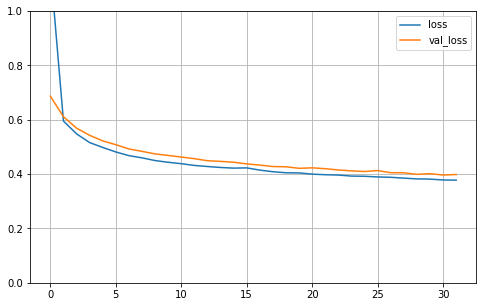

In [6]:
def plot_learning_curvres(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curvres(history)

In [8]:
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a)) a <= x <= b

param_distribution = {
    'hidden_layers': [1,2,3,4],
    'layer_size': np.arange(1, 100),
    'learning_rate': reciprocal(1e-4, 1e-2),
    
}

from sklearn.model_selection import RandomizedSearchCV
random_search_cv = RandomizedSearchCV(sklearn_model,
                                      param_distribution,
                                      n_iter = 10,
                                      cv = 3,
                                      n_jobs =  1)

random_search_cv.fit(x_train_scaled, y_train, epochs=100, 
                     validation_data = (x_valid_scaled,y_valid),
                     callbacks = callbacks)

# cross_validation: 训练集分成n份，n-1份训练，最后一份验证 --> cv

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/100
242/242 [==============================] - 0s 2ms/step - loss: 0.9138 - val_loss: 0.6057
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5708 - val_loss: 0.5500
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4831 - val_loss: 0.4666
Epoch 4/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4350 - val_loss: 0.4415
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4309 - val_loss: 0.4241
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4041 - val_loss: 0.4169
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3915 - val_loss: 0.3994
Epoch 8/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3853 - val_loss: 0.3927
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3778 - val_loss: 0.3943
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3723 - val_lo

242/242 [==============================] - 0s 2ms/step - loss: 0.4160 - val_loss: 0.4295
Epoch 18/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4110 - val_loss: 0.4244
Epoch 19/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4063 - val_loss: 0.4185
Epoch 20/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4018 - val_loss: 0.4155
Epoch 21/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3978 - val_loss: 0.4094
Epoch 22/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3939 - val_loss: 0.4065
Epoch 23/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3904 - val_loss: 0.4034
Epoch 24/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3874 - val_loss: 0.4015
Epoch 25/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3844 - val_loss: 0.3978
Epoch 26/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3814 - val_loss: 

242/242 [==============================] - 0s 2ms/step - loss: 0.3828 - val_loss: 0.4201
Epoch 27/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3800 - val_loss: 0.4148
Epoch 28/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3767 - val_loss: 0.4121
Epoch 29/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3748 - val_loss: 0.4091
Epoch 30/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3717 - val_loss: 0.4069
Epoch 31/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3694 - val_loss: 0.4031
Epoch 32/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3670 - val_loss: 0.4019
Epoch 33/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3645 - val_loss: 0.3999
Epoch 34/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3623 - val_loss: 0.3977
Epoch 35/100
242/242 [==============================] - 1s 2ms/step - loss: 0.3605 - val_loss: 

242/242 [==============================] - 0s 2ms/step - loss: 0.4454 - val_loss: 0.4697
Epoch 18/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4374 - val_loss: 0.4614
Epoch 19/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4304 - val_loss: 0.4529
Epoch 20/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4239 - val_loss: 0.4447
Epoch 21/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4178 - val_loss: 0.4385
Epoch 22/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4126 - val_loss: 0.4330
Epoch 23/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4076 - val_loss: 0.4269
Epoch 24/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4035 - val_loss: 0.4234
Epoch 25/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3993 - val_loss: 0.4180
Epoch 26/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3960 - val_loss: 

242/242 [==============================] - 0s 1ms/step - loss: 0.4592 - val_loss: 0.4745
Epoch 23/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4549 - val_loss: 0.4707
Epoch 24/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4513 - val_loss: 0.4665
Epoch 25/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4475 - val_loss: 0.4626
Epoch 26/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4444 - val_loss: 0.4596
Epoch 27/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4410 - val_loss: 0.4551
Epoch 28/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4380 - val_loss: 0.4536
Epoch 29/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4353 - val_loss: 0.4490
Epoch 30/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4323 - val_loss: 0.4459
Epoch 31/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4298 - val_loss: 

242/242 [==============================] - 0s 1ms/step - loss: 0.5770 - val_loss: 0.6284
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5640 - val_loss: 0.6147
Epoch 11/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5525 - val_loss: 0.6031
Epoch 12/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5424 - val_loss: 0.5920
Epoch 13/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5330 - val_loss: 0.5825
Epoch 14/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5242 - val_loss: 0.5738
Epoch 15/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5164 - val_loss: 0.5651
Epoch 16/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5091 - val_loss: 0.5570
Epoch 17/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5020 - val_loss: 0.5493
Epoch 18/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4957 - val_loss: 

Epoch 35/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5244 - val_loss: 0.5431
Epoch 36/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5209 - val_loss: 0.5391
Epoch 37/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5172 - val_loss: 0.5354
Epoch 38/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5145 - val_loss: 0.5318
Epoch 39/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5113 - val_loss: 0.5287
Epoch 40/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5079 - val_loss: 0.5256
Epoch 41/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5054 - val_loss: 0.5225
Epoch 42/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5027 - val_loss: 0.5195
Epoch 43/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4999 - val_loss: 0.5163
Epoch 44/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4976

242/242 [==============================] - 0s 1ms/step - loss: 0.4321 - val_loss: 0.4476
Epoch 50/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4293 - val_loss: 0.4450
Epoch 51/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4264 - val_loss: 0.4449
Epoch 52/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4246 - val_loss: 0.4382
Epoch 53/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4223 - val_loss: 0.4359
Epoch 54/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4202 - val_loss: 0.4337
Epoch 55/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4178 - val_loss: 0.4315
Epoch 56/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4158 - val_loss: 0.4305
Epoch 57/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4139 - val_loss: 0.4268
Epoch 58/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4124 - val_loss: 

242/242 [==============================] - 0s 1ms/step - loss: 0.6945 - val_loss: 0.7461
Epoch 28/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6892 - val_loss: 0.7409
Epoch 29/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6843 - val_loss: 0.7359
Epoch 30/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6797 - val_loss: 0.7312
Epoch 31/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6752 - val_loss: 0.7265
Epoch 32/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6709 - val_loss: 0.7220
Epoch 33/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6667 - val_loss: 0.7176
Epoch 34/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6628 - val_loss: 0.7134
Epoch 35/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6589 - val_loss: 0.7093
Epoch 36/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6552 - val_loss: 

Epoch 31/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6164 - val_loss: 0.6752
Epoch 32/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6132 - val_loss: 0.6714
Epoch 33/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6101 - val_loss: 0.6677
Epoch 34/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6071 - val_loss: 0.6642
Epoch 35/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6042 - val_loss: 0.6607
Epoch 36/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6014 - val_loss: 0.6574
Epoch 37/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5986 - val_loss: 0.6541
Epoch 38/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5959 - val_loss: 0.6510
Epoch 39/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5932 - val_loss: 0.6479
Epoch 40/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5906

242/242 [==============================] - 0s 1ms/step - loss: 0.6110 - val_loss: 0.6799
Epoch 48/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6080 - val_loss: 0.6768
Epoch 49/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6051 - val_loss: 0.6738
Epoch 50/100
242/242 [==============================] - 0s 1ms/step - loss: 0.6023 - val_loss: 0.6709
Epoch 51/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5995 - val_loss: 0.6680
Epoch 52/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5968 - val_loss: 0.6651
Epoch 53/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5942 - val_loss: 0.6623
Epoch 54/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5916 - val_loss: 0.6597
Epoch 55/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5891 - val_loss: 0.6570
Epoch 56/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5866 - val_loss: 

Epoch 54/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5842 - val_loss: 0.6083
Epoch 55/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5825 - val_loss: 0.6064
Epoch 56/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5808 - val_loss: 0.6045
Epoch 57/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5792 - val_loss: 0.6029
Epoch 58/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5777 - val_loss: 0.6010
Epoch 59/100
121/121 [==============================] - 0s 771us/step - loss: 0.5245
Epoch 1/100
242/242 [==============================] - 0s 2ms/step - loss: 4.5550 - val_loss: 3.5844
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 2.7512 - val_loss: 2.3606
Epoch 3/100
242/242 [==============================] - 0s 2ms/step - loss: 1.8765 - val_loss: 1.7428
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 1.4236 - val_loss: 1.4084
E

242/242 [==============================] - 0s 1ms/step - loss: 2.1140 - val_loss: 1.9748
Epoch 5/100
242/242 [==============================] - 0s 1ms/step - loss: 1.7621 - val_loss: 1.6693
Epoch 6/100
242/242 [==============================] - 0s 1ms/step - loss: 1.5052 - val_loss: 1.4467
Epoch 7/100
242/242 [==============================] - 0s 1ms/step - loss: 1.3185 - val_loss: 1.2858
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 1.1827 - val_loss: 1.1709
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 1.0850 - val_loss: 1.0903
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 1.0131 - val_loss: 1.0309
Epoch 11/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9601 - val_loss: 0.9878
Epoch 12/100
242/242 [==============================] - 0s 2ms/step - loss: 0.9197 - val_loss: 0.9554
Epoch 13/100
242/242 [==============================] - 0s 1ms/step - loss: 0.8880 - val_loss: 0.929

Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4805 - val_loss: 0.5027
Epoch 11/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4721 - val_loss: 0.4890
Epoch 12/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4638 - val_loss: 0.4836
Epoch 13/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4582 - val_loss: 0.4760
Epoch 14/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4518 - val_loss: 0.4684
Epoch 15/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4464 - val_loss: 0.4618
Epoch 16/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4414 - val_loss: 0.4546
Epoch 17/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4363 - val_loss: 0.4503
Epoch 18/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4320 - val_loss: 0.4462
Epoch 19/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4279

242/242 [==============================] - 0s 2ms/step - loss: 0.5292 - val_loss: 0.5875
Epoch 7/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5079 - val_loss: 0.5652
Epoch 8/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4881 - val_loss: 0.5473
Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4716 - val_loss: 0.5253
Epoch 10/100
242/242 [==============================] - 1s 2ms/step - loss: 0.4574 - val_loss: 0.5084
Epoch 11/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4446 - val_loss: 0.4953
Epoch 12/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4341 - val_loss: 0.4844
Epoch 13/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4254 - val_loss: 0.4738
Epoch 14/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4183 - val_loss: 0.4636
Epoch 15/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4121 - val_loss: 0.4

242/242 [==============================] - 0s 2ms/step - loss: 0.3582 - val_loss: 0.3869
Epoch 9/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3564 - val_loss: 0.3846
Epoch 10/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3470 - val_loss: 0.3827
Epoch 11/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3452 - val_loss: 0.3891
Epoch 12/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3370 - val_loss: 0.3731
Epoch 13/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3367 - val_loss: 0.3612
Epoch 14/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3297 - val_loss: 0.3660
Epoch 15/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3276 - val_loss: 0.3782
Epoch 16/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3273 - val_loss: 0.3548
Epoch 17/100
242/242 [==============================] - 0s 2ms/step - loss: 0.3199 - val_loss: 0

242/242 [==============================] - 0s 1ms/step - loss: 0.5170 - val_loss: 0.5652
Epoch 23/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5115 - val_loss: 0.5594
Epoch 24/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5063 - val_loss: 0.5532
Epoch 25/100
242/242 [==============================] - 0s 2ms/step - loss: 0.5014 - val_loss: 0.5469
Epoch 26/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4967 - val_loss: 0.5413
Epoch 27/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4921 - val_loss: 0.5359
Epoch 28/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4879 - val_loss: 0.5306
Epoch 29/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4838 - val_loss: 0.5260
Epoch 30/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4801 - val_loss: 0.5215
Epoch 31/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4765 - val_loss: 

Epoch 51/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4549 - val_loss: 0.5030
Epoch 52/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4525 - val_loss: 0.4999
Epoch 53/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4504 - val_loss: 0.4971
Epoch 54/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4481 - val_loss: 0.4944
Epoch 55/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4459 - val_loss: 0.4920
Epoch 56/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4436 - val_loss: 0.4894
Epoch 57/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4417 - val_loss: 0.4872
Epoch 58/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4397 - val_loss: 0.4850
Epoch 59/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4377 - val_loss: 0.4825
Epoch 60/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4358

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f3061313438>,
                   iid='warn', n_iter=10, n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2, 3, 4],
                                        'layer_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 3...46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f30142173c8>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_s

In [9]:
from scipy.stats import reciprocal
reciprocal.rvs(1e-4, 1e-2, size=10)

array([0.00012491, 0.00176283, 0.00420658, 0.00250656, 0.00084328,
       0.00300121, 0.00746339, 0.00172042, 0.00365631, 0.00224155])

In [10]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

{'hidden_layers': 3, 'layer_size': 94, 'learning_rate': 0.005899898782143167}
-0.34141796827316284


In [11]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

162/162 [==============================] - 0s 781us/step - loss: 0.3717


0.37169551849365234